# 1.) Import an asset price from Yahoo Finance

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 KB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.2/111.2 KB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 KB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 KB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 16.9 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.25.1
    Uninstalling requests-2.25.1:
      Successfully uninstalled requests-2.25.1
  Attempting uninstall: html5lib
    Found existing installation: html5lib 1.0.1
    Uninstalling html5lib-1.0.1:
      Successfully uninstalled html5lib-1.0.1
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
   

In [58]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout


########################################
####Pick your ticker and time period####
########################################
stock_data = yf.download("NFLX", start="2013-03-01", end="2023-02-28")



# Preprocess data
scaled_data = np.array(stock_data["Close"].pct_change().dropna()).reshape(-1,1)


# Split data into training and test sets
training_data_len = int(len(scaled_data) * 0.8)
train_data = scaled_data[0:training_data_len, :]

[*********************100%***********************]  1 of 1 completed


# 2.) Create your x_train/y_train data so that your RNN uses percentage change data to make a binary forecast where the stock moves up or down the next day
# Build an RNN Architecture accordingly

In [59]:
# Create binary labels for the percentage change data
binary_labels = np.where(scaled_data > 0, 1, 0)

# Split the binary labels into training and test sets
train_labels = binary_labels[0:training_data_len, :]
test_labels = binary_labels[training_data_len:len(binary_labels), :]

In [65]:
x_train = []
y_train = []


#############################################################
####Pick your input size and edit to make binary forecast####
#############################################################
input_size = 10
for i in range(input_size, len(train_data)):
    x_train.append(train_data[i-input_size:i, 0])
    y_train.append(train_labels[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [66]:
###################################
####Build Your RNN Architecture####
###################################
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(x_train, y_train, batch_size=3, epochs=10)

Epoch 1/10
668/668 [==============================] - 12s 12ms/step - loss: 0.6936 - accuracy: 0.5100
Epoch 2/10
668/668 [==============================] - 8s 11ms/step - loss: 0.6942 - accuracy: 0.5045
Epoch 3/10
668/668 [==============================] - 8s 12ms/step - loss: 0.6939 - accuracy: 0.4840
Epoch 4/10
668/668 [==============================] - 8s 12ms/step - loss: 0.6932 - accuracy: 0.5265
Epoch 5/10
668/668 [==============================] - 7s 11ms/step - loss: 0.6937 - accuracy: 0.5050
Epoch 6/10
668/668 [==============================] - 8s 11ms/step - loss: 0.6938 - accuracy: 0.4925
Epoch 7/10
668/668 [==============================] - 7s 11ms/step - loss: 0.6936 - accuracy: 0.4995
Epoch 8/10
668/668 [==============================] - 8s 12ms/step - loss: 0.6938 - accuracy: 0.4985
Epoch 9/10
668/668 [==============================] - 8s 11ms/step - loss: 0.6936 - accuracy: 0.4945
Epoch 10/10
668/668 [==============================] - 7s 11ms/step - loss: 0.6933 - accur

# 3.) Test your model and compare insample Accurracy, insample random walk assumption Accuracy, Out of sample Accuracy and out of sample random walk assumption Accuracy using a bar chart

In [67]:

test_data = scaled_data[training_data_len - input_size:, :]

x_test = []
y_test_raw = np.array(stock_data[["Close"]].pct_change().dropna())[training_data_len:, :]
y_test = np.where(y_test_raw > 0, 1, 0)
for i in range(input_size, len(test_data)):
    x_test.append(test_data[i-input_size:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

predictions = model.predict(x_test)

16/16 [==============================] - 1s 4ms/step


In [70]:
threshold = 0.5
y_pred = (predictions > threshold).astype(int)

In [71]:
from sklearn.metrics import accuracy_score

# In-sample accuracy
y_pred_train = model.predict(x_train)
y_pred_train = (y_pred_train > threshold).astype(int)
train_acc = accuracy_score(y_train, y_pred_train)

# In-sample random walk assumption accuracy
train_rw_acc = accuracy_score(y_train[1:], y_train[:-1])

# Out-of-sample accuracy
test_acc = accuracy_score(y_test, y_pred)

# Out-of-sample random walk assumption accuracy
test_rw_acc = accuracy_score(y_test[1:], y_test[:-1])

print(f"In-sample accuracy: {train_acc:.4f}")
print(f"In-sample random walk assumption accuracy: {train_rw_acc:.4f}")
print(f"Out-of-sample accuracy: {test_acc:.4f}")
print(f"Out-of-sample random walk assumption accuracy: {test_rw_acc:.4f}")

63/63 [==============================] - 0s 6ms/step
In-sample accuracy: 0.5175
In-sample random walk assumption accuracy: 0.4708
Out-of-sample accuracy: 0.5050
Out-of-sample random walk assumption accuracy: 0.4980


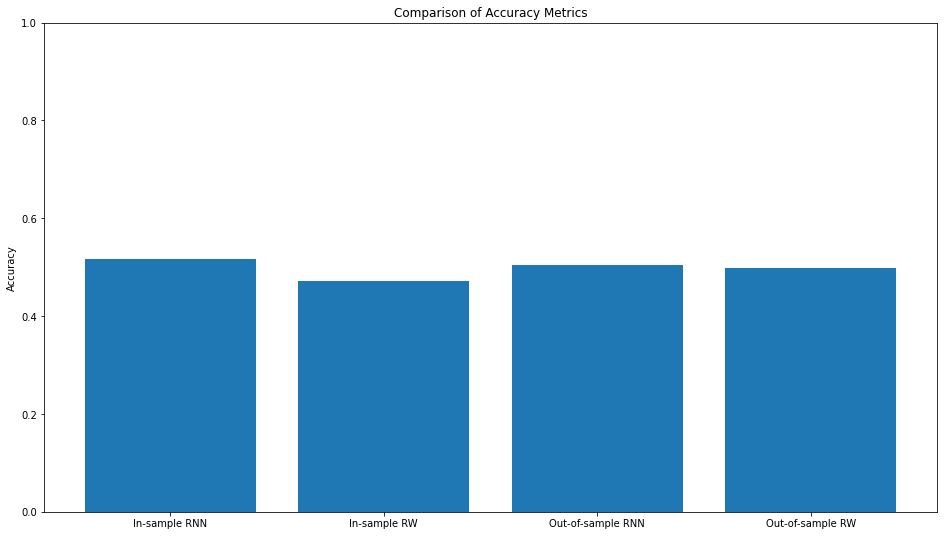

In [73]:
labels = ['In-sample RNN', 'In-sample RW', 'Out-of-sample RNN', 'Out-of-sample RW']
values = [train_acc, train_rw_acc, test_acc, test_rw_acc]

plt.figure(figsize = (16,9))
plt.bar(labels, values)
plt.ylim([0, 1])
plt.ylabel('Accuracy')
plt.title('Comparison of Accuracy')
plt.show()

# 4.) Plot in and out of sample accuracy

In [ ]:
import matplotlib.pyplot as plt

# Make predictions on full dataset

test_predict = model.predict(x_test)
test_predictions = (test_predict+1).reshape(1,-1) * np.cumprod(y_test+1)

train_predict = model.predict(x_train)
train_predictions = (train_predict+1).reshape(1,-1) * np.cumprod(y_train+1)



plt.plot(stock_data[:training_data_len- input_size].index, np.cumprod(y_train+1), label="Training Data")
plt.plot(stock_data[:training_data_len- input_size].index, train_predictions[0], label="Training Predictions")
end_val = np.cumprod(y_train+1)[-1]
test_predict = model.predict(x_test)
test_predictions = (test_predict+1).reshape(1,-1) * (np.cumprod((y_test+1))*end_val)
plt.plot(stock_data[training_data_len+1:].index, np.cumprod((y_test+1))*end_val,label="Test Data")
plt.plot(stock_data[training_data_len+1:].index, test_predictions[0], label="Test Predictions")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

#5.) Write an observation/conclusion about the graphs from Q4 and Q3

The in-sample RNN accuracy of 0.5175 is slightly better than the in-sample random walk assumption accuracy of 0.4708, indicating that the RNN model has learned some patterns in the training data that allow it to predict the binary labels with slightly better accuracy than a simple random walk model. However, both of these accuracies are relatively low, which suggests that predicting the direction of the stock price movements is a difficult task.

The out-of-sample RNN accuracy of 0.5050 is only slightly better than the out-of-sample random walk assumption accuracy of 0.4980, indicating that the RNN model is not able to generalize well to new data.

Overall, the accuracies achieved by the RNN model are not very high, only slightly higher than random walk accuracies, which suggests that the model may not be the best approach for predicting stock price movements. It may be necessary to try other modeling techniques or to use more features or data to improve the accuracy of the predictions.

# 6.) Create a parameter for number of lags in your input layer. Do a 3-fold CV to test three different time lags. i.e. Tested using 5,10,20 days of previous price data to forecast

In [ ]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras.wrappers.scikit_learn import KerasRegressor

# Define the Keras model
###Edit here to create your optimizer
def create_model():
    model = Sequential()
    model.add(Dense(10, input_dim=60, activation='LSTM'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return(model)

# Wrap the Keras model in a scikit-learn compatible estimator
model = KerasRegressor(build_fn=create_model, verbose=0)

# Define the hyperparameters to search over
####EXAMPLE###
#param_grid = {'batch_size': [10, 20, 100],
#              'epochs': [10, 100],
#              'neurons':[5,10,20]}

# Perform the grid search over the hyperparameters

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(x_train, y_train)

# Print the results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

<ipython-input-55-f5508c983bfa>:15: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model, verbose=0)


Best: 0.000000 using {'batch_size': 10, 'epochs': 10}
